# Jacobian 

![](pic_resource/jacobian_deriv_1.png)

## Interpretation of Jacobian -- J

Each column of Jacobian matrix describes the vector of Cartesian velocity which results solely from the movement of joint change $\Delta$q .
![](pic_resource/jacobian_deriv_2.png)

## Interpretation of Inverse Jacobian -- J<sup>-1</sup>

Each column of J<sup>-1</sup> describes the vector of $\Delta$q which results solely from the movement of $\Delta$x, $\Delta$y, $\Delta$z in Cartesian coordinate.

Which means, for infinitesimal changes in Cartesian coordinate, we are able to calculate the change of joints.
![](pic_resource/jacobian_deriv_3.png)

# Implementation
![](pic_resource/jacobian_arm.png)

In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from math import cos, sin
from math import sqrt

### Define Arm model

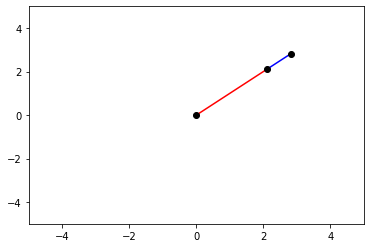

In [2]:
class TwoLinkArm:
    def __init__(self, joint_angles= [0, 0]):
        self.shoulder = np.array([0, 0])
        self.link_lengths = [3, 1]
        self.update_joints(joint_angles)
        
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.forward_kinematics()
        return [self.elbow, self.wrist]
        
    def forward_kinematics(self):
        theta0 = self.joint_angles[0]
        theta1 = self.joint_angles[1]
        l0 = self.link_lengths[0]
        l1 = self.link_lengths[1]
        self.elbow = self.shoulder + np.array([l0 * cos(theta0), l0 * sin(theta0)])
        self.wrist = self.elbow + np.array([l1 * cos(theta0 + theta1), l1 * sin(theta0 + theta1)])
        
    def inverse_kinematics(self, x, y):
        theta1 = np.pi - np.arccos((self.link_lengths[0]**2 + self.link_lengths[1]**2 - x**2 - y**2) / (2*self.link_lengths[0]*self.link_lengths[1]))
        theta0 = np.arctan2(y, x) - np.arccos((self.link_lengths[0]**2 + x**2 + y**2 - self.link_lengths[1]**2) / (2*self.link_lengths[0]*((x**2 + y**2)**0.5)))
        return [theta0, theta1]
        
    def plot(self):
        plt.axis([-5,5,-5,5])
        plt.plot([self.shoulder[0], self.elbow[0]], [self.shoulder[1], self.elbow[1]], 'r-')
        plt.plot([self.elbow[0], self.wrist[0]], [self.elbow[1], self.wrist[1]], 'b-')
        plt.plot(self.shoulder[0], self.shoulder[1], 'ko')
        plt.plot(self.elbow[0], self.elbow[1], 'ko')
        plt.plot(self.wrist[0], self.wrist[1], 'ko')
 

arm = TwoLinkArm([pi/4, 0])
arm.plot()

### Define Inverse Jacobian matrix function
* **q1:**   current q1
* **q2:**   current q2
* **l1:**   link1 length
* **l2:**   link2 length
* **d_x:**  change of x
* **d_y:**  change of y

In [3]:
def inv_jacobian(q1, q2, l1, l2, displacement):
    # q1: current q1
    # q2: current q2
    # l1: link1 length
    # l2: link2 length
    # d_x: change of x
    # d_y: change of y
    
    # Jacobian matrix
    J = [[-l2*sin(q1+q2)-l1*sin(q1), -l2*sin(q1+q2)],
        [l2*cos(q1+q2)+l1*cos(q1), l2*cos(q1+q2)]]
    
    # Pseudo-inverse Jacobian matrix
    inv_J = np.linalg.pinv(J)
    
    # given change of (x,y), calculate change of joint angle
    dq = inv_J @ displacement
    
    return dq

### Path-planing with Jacobian in interactable timestep

Maximun joint speed:  0.087 rad
Original position:  [2.121 3.121]
Desired position:  [ 2.366 -2.098]

 
Simulating time step


interactive(children=(IntSlider(value=99, description='sim_t', max=199), Output(layout=Layout(height='300px'))…

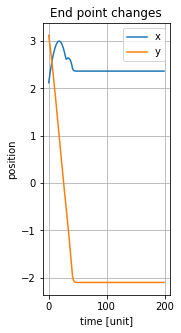

In [4]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.rcParams["figure.figsize"]=5,5

# Simulation time steps
t = 200
dt = np.arange(0, t)

# Assume joint0 and joint1 are able to rotate 5 degree per unit time
joint_max_rad = 5 / 180 * np.pi
print("Maximun joint speed: ", np.round(joint_max_rad, 3), "rad")

### Initialization
## Initialize async-p2p arm
arm = TwoLinkArm([pi/4, pi/4])
current_theta = np.zeros((t,2))
current_position = np.zeros((t,2))
current_position[0] = arm.wrist
current_theta[0] = arm.inverse_kinematics(current_position[0][0], current_position[0][1])
print("Original position: ", np.round(current_position[0], 3))


### Set desired goal (position or joint angle)
## Set desired position (x, y)
# desired_position = [-0.5, 0.9]
# desired_theta = arm.inverse_kinematics(desired_position[0], desired_position[1])

## Set desired joint angle (joint1, joint2)
desired_theta = np.array([-pi/3, pi/2])
desired_position = arm.update_joints(desired_theta)[1]
print("Desired position: ", np.round(desired_position, 3))


###Simulate arm movement
## create tmp variable
distance = np.zeros((t,2))
dif_theta = np.zeros((t,2))

## Pre-calculate change distance for each timestep
distance[0] = desired_position - current_position[0]

# jacobian gain factor
jacobian_gain_factor = 0.5

# define arm link length
l1, l2 = arm.link_lengths

## Simulate in timestepscurrent_theta
for i in range(t):
    # given change in cartesian coordinate, obtain joint change by using inverse jacobian
    dif_theta[i] = inv_jacobian(current_theta[i][0], current_theta[i][1], l1, l2, distance[i])
    
    # Limit angle change in maximum speed 
    dif_theta[i] = np.where(dif_theta[i] > joint_max_rad, joint_max_rad, dif_theta[i])
    dif_theta[i] = np.where(dif_theta[i] < -joint_max_rad, -joint_max_rad, dif_theta[i])

    if i < t-1:
        # Update current angle
        current_theta[i+1] = current_theta[i] + (jacobian_gain_factor * dif_theta[i]) 
        # Forward kinematics, calculate current end position
        arm.update_joints(current_theta[i+1])
        current_position[i+1] = arm.wrist
        # Update remaining distance
        distance[i+1] = desired_position - current_position[i+1]
    

# Plot end point changes
ax = plt.subplot(121)
ax.set_xlabel('time [unit]')
ax.set_ylabel('position')
ax.plot(dt, current_position[:])
ax.set_aspect('auto')
ax.legend(['x', 'y'])
ax.set_title('End point changes')
ax.grid()

# Interactive time simulation plot
def iterpolation(sim_t):
    # Update arm according to sim_t
    arm.update_joints(current_theta[sim_t])
    arm.plot()
    plt.text(arm.wrist[0], arm.wrist[1], np.round(arm.wrist, 2))
    ax.set_title('Jacobian path-planing')
    plt.grid()

# Interation function 
print("\n \nSimulating time step")
interactive_plot = interactive(iterpolation, sim_t=(0, t-1, 1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot
